# Testing 3D cells recovery from Tetrapod snapshots

## Import Libraries

In [1]:
## autoreloading
%load_ext autoreload
%autoreload 2

In [2]:
## Standard libraries
import os
import numpy as np
import copy
import random
import pickle
import enum
import time
import glob
from pathlib import Path

## Image processing stuff
from skimage import io
from skimage.filters import gaussian
from skimage.transform import rescale
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.color import label2rgb
from skimage.morphology import ball
from scipy.ndimage import gaussian_filter, zoom, affine_transform
from scipy import ndimage as ndi
from PIL import Image
from tifffile import imwrite, imread

## Smoothing filter
from scipy.signal import savgol_filter

## Scipy optimization
from scipy.optimize import minimize

## Stardist matching
from stardist.matching import matching

## Pandas/Seaborn for dataframe & boxplots
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

## multiprocessing stuff
import multiprocessing

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
# %matplotlib inline
%matplotlib notebook

## Plotly for animations 
import plotly.express as px

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

## Torchvision
import torchvision
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import random

## TorchIO
import torchio as tio

## MONAI
from monai.networks.nets import BasicUNet, UNet

## Autoreload
%reload_ext autoreload

## Setting the seed
seed = 42
random.seed(seed)
torch.manual_seed(seed)

## Test paths and filenames

In [3]:
# Path to test set segmented cells and their approx. background masks
path_test_st = 'Exp Dataset/Testing/CM/'
path_test_tp = 'Exp Dataset/Testing/TP/'

# file names of test set
filenames_st = sorted(glob.glob(path_test_st + "*.tif"))
filenames_tp = sorted(glob.glob(path_test_tp + "*.tif"))

### GPU for calc.

In [4]:
# gpu id
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Transforms

### Correct dimension ordering

In [5]:
# transform permutes the dimension to compyl with the pytorch convention of DxHxW
class MyTransform(tio.transforms.Transform):
    def apply_transform(self, subject):
        st = subject['ST'][tio.DATA]
        tp = subject['TP'][tio.DATA]
        st = st.permute(0,3,2,1)
        tp = tp.permute(0,3,2,1)
        subject['ST'][tio.DATA] = st
        subject['TP'][tio.DATA] = tp
        return subject

# dimension correcting transform
my_transform = MyTransform()

### Focus shifting in Z

In [6]:
# grid size in Z
Dinit = 60  # original number of slices in each pre-processed stack
Dc = 50  # number of slices in Z after throwing away extras for focus augmentation
Dextra = (Dinit - Dc)//2  # number of slices to throw away from each side

# define the transform that shifts the z-range to tolerate some inaccuracy in focus finding
class FocusTransform(tio.transforms.Transform):
    def apply_transform(self, subject):
        
        # extract current st and tp 
        st = subject['ST'][tio.DATA]
        tp = subject['TP'][tio.DATA]
        
        # save shifted and cropped st and tp
        subject['ST'][tio.DATA] = st[:,Dextra:-Dextra]
        subject['TP'][tio.DATA] = tp[:,Dextra:-Dextra]
        return subject

# focus shifting in z transform
focus_transform = FocusTransform()

### Normalization and composition

In [7]:
# normalization of data with percentiles to avoid single cell sensitivity
norm_transform = tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0.5, 99.95), exclude='ST')

# for validation/testing only normalize after permuting
transforms_valid = tio.Compose([my_transform, norm_transform, focus_transform])

### Transform testing

In [8]:
# define a subejct with paths
subject_test = tio.Subject({'ST': tio.ScalarImage(filenames_st[0]),
                            'TP': tio.ScalarImage(filenames_tp[0])})

# dimensions according to torchio convention
print(subject_test['ST'][tio.DATA].shape)

# apply my transform
subject_after = my_transform(subject_test)

# new dimensions according to DxHxW and cropped
print(subject_after['ST'][tio.DATA].shape)
print(subject_after['TP'][tio.DATA].shape)

torch.Size([1, 320, 320, 60])
torch.Size([1, 60, 320, 320])
torch.Size([1, 60, 320, 320])


## Test set subjects dataset

In [9]:
# create subjects out of my paths
subjects = []
for i, (st_path, tp_path) in enumerate(zip(filenames_st, filenames_tp)):
    subject = tio.Subject(
        ST=tio.ScalarImage(st_path),
        TP=tio.ScalarImage(tp_path)
    )
    subjects.append(subject)
num_test = len(subjects)
print('Test set size:', num_test, 'spheroids')
test_set = tio.SubjectsDataset(subjects, transform=transforms_valid)
test_set[0]['ST'][tio.DATA].shape

Test set size: 20 spheroids


torch.Size([1, 50, 320, 320])

## Testing: Realistic simulation + Experimental

### Pred-trained focus estimation model

In [10]:
# focus model is a unet with global avg pool at the output
class ModelFocus(nn.Module):
    def __init__(self):
        super(ModelFocus, self).__init__()
        self.base_model = BasicUNet(spatial_dims=2,
                                    in_channels=1,
                                    out_channels=64,
                                    features=(64, 64, 128, 256, 512, 64))
        self.out_layers = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=1), 
                                        nn.Conv2d(64, 1, kernel_size=1))
    def forward(self, x):
        return self.out_layers(self.base_model(x)).squeeze()

# instantiate model and transfer to device
model_focus = ModelFocus()
model_focus = model_focus.to(device)

# load pretrained weights and put on eval mode
ckpt = torch.load('Models/Focus_finder_TP_model_best_ckpt.pth')
model_focus.load_state_dict(ckpt['weights'])
model_focus.eval()

# ensure that all focus model parameters do not require gradients and put in it eval mode
for param in model_focus.parameters():
    param.requires_grad = False

BasicUNet features: (64, 64, 128, 256, 512, 64).


### Pre-trained 3D segmentation model

In [11]:
# instantiate architecture with right # of input channels
model = BasicUNet(spatial_dims=2,
                  in_channels=2,
                  out_channels=Dc,
                  features=(64, 64, 128, 256, 512, 64)).to(device)

# load saved checkpoint
weights_name = 'Models/Cellsnap_3D_segmentor_TP'
ckpt = torch.load(weights_name + '_model_best_ckpt.pth')
model.load_state_dict(ckpt['weights'])
model.eval()

BasicUNet features: (64, 64, 128, 256, 512, 64).


<All keys matched successfully>

### Focus normalization function

In [12]:
# parameters defining discretization in z
pz = 4  # pixel size in z in [um]
focus_mid = torch.LongTensor([20]).to(device)  # focal position of the optimal TP slice assuming no shift
focus_rng = torch.LongTensor([0, 35]).to(device)  # range of interesting focal positions in slices of pz microns
two = torch.LongTensor([2]).to(device)

# normalization functions for the focus
def normalize_focus(f, fmid, frng): return (f - fmid)/((frng[1] - frng[0])/two)
def unnormalize_focus(f, fmid, frng): return f*(frng[1] - frng[0])/two + fmid

### Batch preparation function

In [13]:
# preparing a single batch from the training loader
eps = torch.FloatTensor([1e-8]).to(device)
thresh = torch.FloatTensor([0.1]).to(device)
def prepare_batch(batch, device):
    st = batch['ST'][tio.DATA].to(device)
    tp = batch['TP'][tio.DATA].to(device)
    st = st.squeeze(1)
    st = torch.where(st >= thresh, torch.ones_like(st), torch.zeros_like(st))
    batch_size, C, D, H, W = tp.shape
    focus_tp = torch.randint(low=focus_rng[0], high=focus_rng[1]+1, size=(batch_size,)).to(device)
    tp2d = torch.gather(tp, 2, focus_tp.view(batch_size,1,1,1,1).expand(batch_size,C,1,H,W)).squeeze(1)
    tp2d = (tp2d - tp2d.mean(dim=(-1,-2), keepdim=True))/(tp2d.std(dim=(-1,-2), keepdim=True) + eps)
    with torch.set_grad_enabled(False):
        focus_tp_est = model_focus(tp2d)
    f2d = focus_tp_est.view(batch_size,1,1,1).expand(batch_size,C,H,W)
    return tp2d, f2d, st

### Transfering from torch to numpy

In [14]:
# function to transfer stuff to numpy
def to_np(tensor):
    return tensor.cpu().numpy().squeeze()

### Stack-pair colorization function

In [15]:
def normalize_percentile(stack):
    stack_norm = np.copy(stack).astype(float)
    min_bf, max_bf = np.percentile(stack_norm, [0.1, 99.9])
    stack_norm -= min_bf
    stack_norm /= (max_bf - min_bf)
    stack_norm[stack_norm<0] = 0
    stack_norm[stack_norm>1] = 1
    stack_norm *= 255
    return stack_norm

def colorize_stack_pair(stack1, stack2):
    stack_out = []
    colors = np.array([[0,1,1], [1,0,0]])  # [237./255, 41./255, 57./255] 
    stack1_norm = normalize_percentile(stack1)
    stack2_norm = normalize_percentile(stack2)
    for img1, img2 in zip(stack1_norm, stack2_norm):
        img1 = np.tile(img1, [3, 1, 1])
        for i, c in enumerate(colors[0]):
            img1[i] *= c
        img2 = np.tile(img2, [3, 1, 1])
        for i, c in enumerate(colors[1]):
            img2[i] *= c
        stack_out += [(img1+img2)/2]
    stack_out = np.stack(stack_out, axis=0)
    return (stack_out/stack_out.max()*255).astype(np.uint8)

### Analyze subjects 1 by 1 - Focus scan 

In [16]:
# get subjects one by one
inputs_f, outputs_f, targets_f, foci_f = [], [], [], []
ts_all = time.time()
for i in range(len(test_set)):
    
    # time each subject
    tsi = time.time()
    
    # current test subject
    subjecti = test_set[i]
    
    # save current inputs and targets for entire subject prior to patches
    sti = subjecti['ST'][tio.DATA].to(device)
    tpi = subjecti['TP'][tio.DATA].to(device)
    tpi = (tpi - tpi.mean(dim=(-1,-2), keepdim=True))/(tpi.std(dim=(-1,-2), keepdim=True) + eps)
    tpi = tpi[:, focus_rng[0]:(focus_rng[1]+1)]
    C, D, H, W = tpi.shape
    with torch.no_grad():
        focus_tpi = model_focus(tpi.permute(1,0,2,3))
    fpi = focus_tpi.view(1,D,1,1).expand(C,D,H,W)
    inputs_f.append(tpi.cpu())
    targets_f.append(sti.cpu())
    foci_f.append(unnormalize_focus(focus_tpi, focus_mid, focus_rng).cpu())
    
    # permute batch and depth dimensions and concatenate TP and focus
    tpi = tpi.permute(1,0,2,3)
    fpi = fpi.permute(1,0,2,3)
    tpi = torch.cat((tpi, fpi), axis=1)
    
    # predict all focuses as a batch
    with torch.no_grad():
        outputsi = torch.sigmoid(model(tpi))
    outputs_f.append(outputsi.detach().cpu())

    # report time it took to process current subject
    print(f'Subject {i} Took {time.time()-tsi:.2f} Seconds')

# overall processing time
tf_all = time.time()
print(f'All Test Subjects Processed in {tf_all - ts_all:.2f} Seconds')

Subject 0 Took 1.47 Seconds
Subject 1 Took 1.34 Seconds
Subject 2 Took 1.32 Seconds
Subject 3 Took 1.50 Seconds
Subject 4 Took 1.38 Seconds
Subject 5 Took 1.33 Seconds
Subject 6 Took 1.35 Seconds
Subject 7 Took 1.37 Seconds
Subject 8 Took 1.32 Seconds
Subject 9 Took 1.36 Seconds
Subject 10 Took 1.38 Seconds
Subject 11 Took 1.35 Seconds
Subject 12 Took 1.34 Seconds
Subject 13 Took 1.43 Seconds
Subject 14 Took 1.51 Seconds
Subject 15 Took 1.71 Seconds
Subject 16 Took 1.74 Seconds
Subject 17 Took 1.61 Seconds
Subject 18 Took 1.67 Seconds
Subject 19 Took 1.73 Seconds
All Test Subjects Processed in 29.21 Seconds


### Test inputs per focus


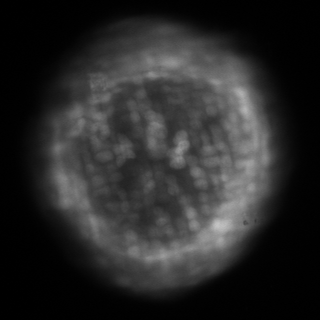
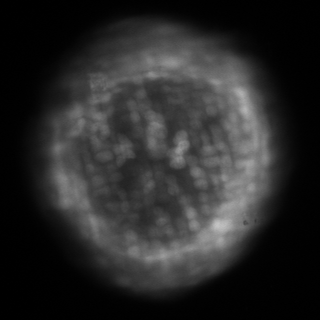
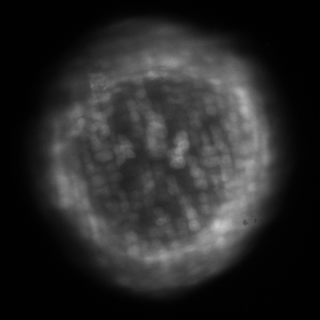
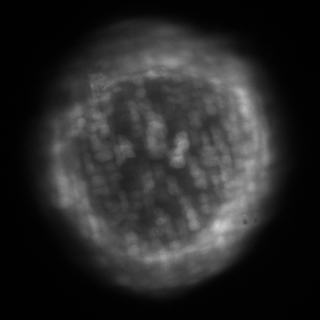
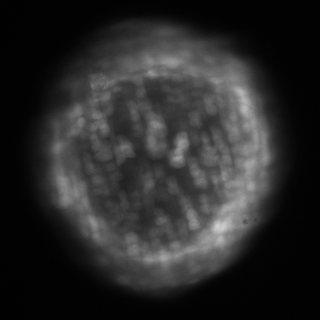
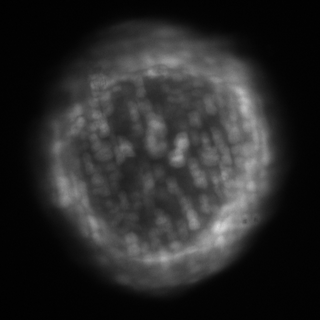
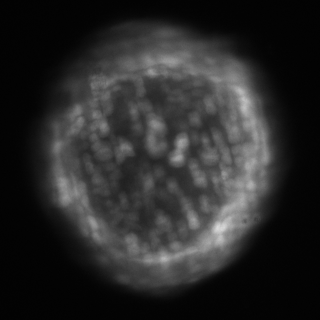
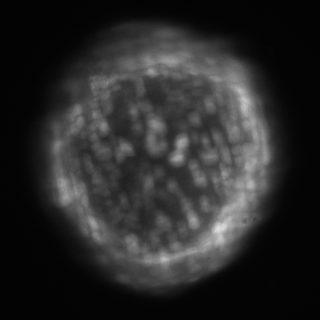
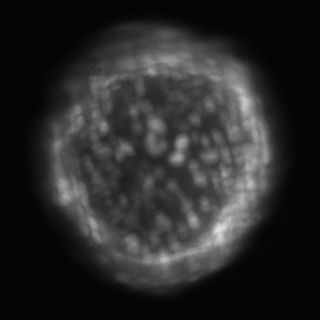
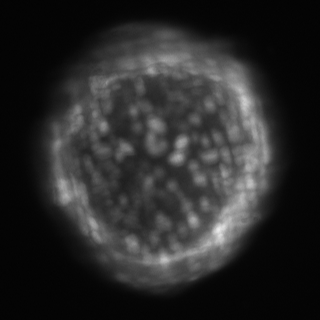
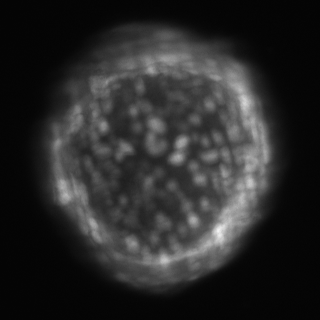
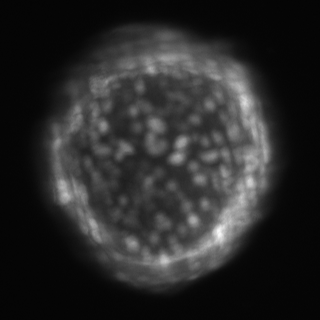
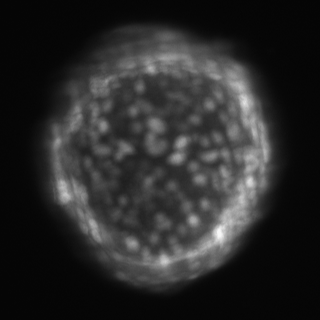
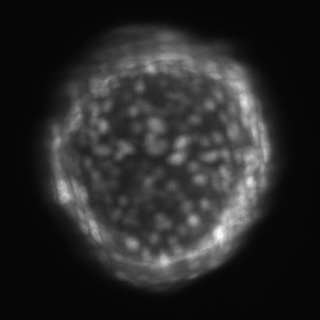
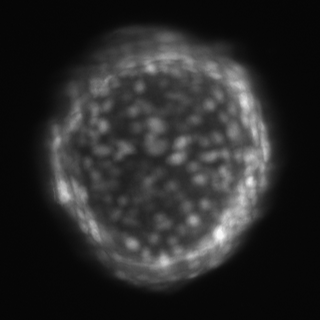
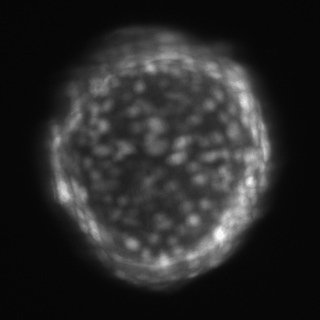
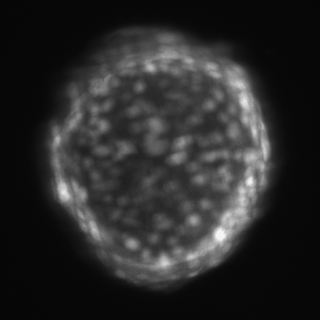
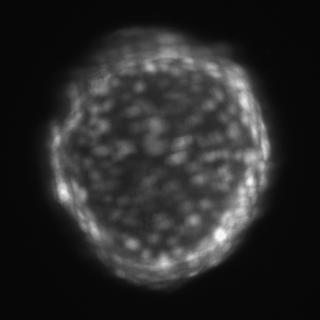
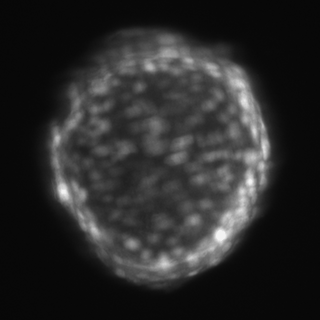
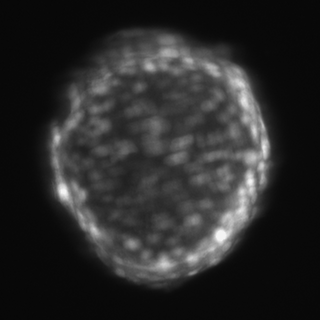
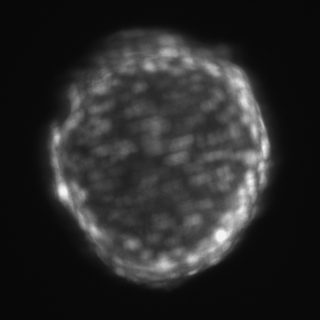
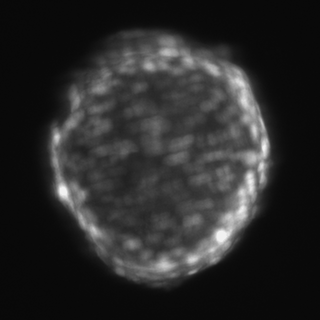
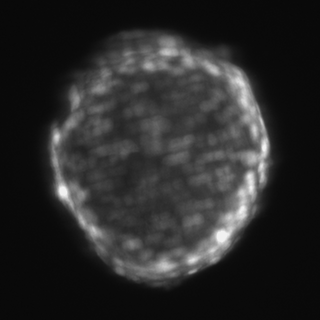
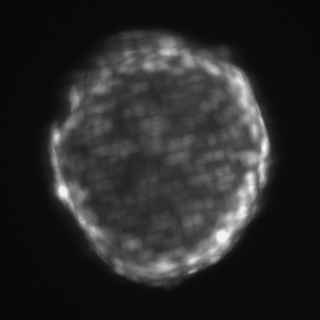
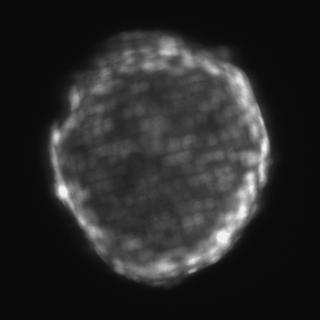
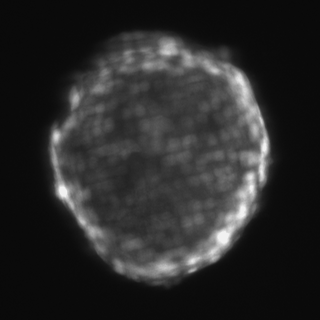
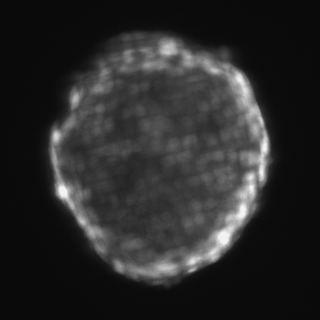
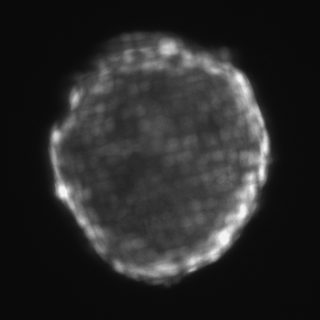
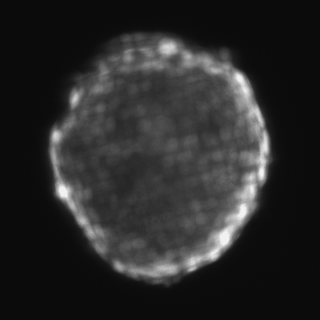
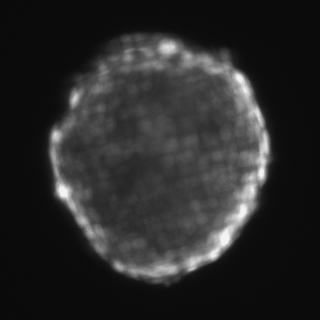
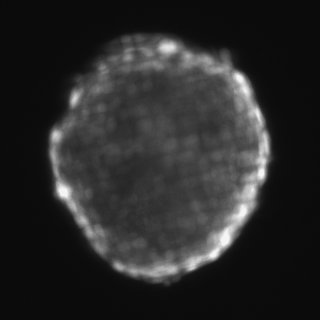
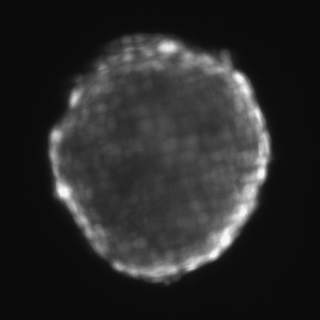
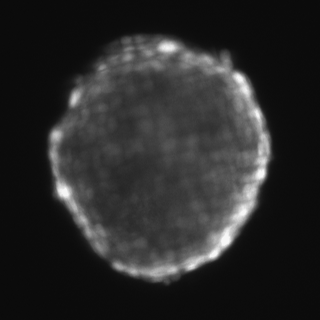
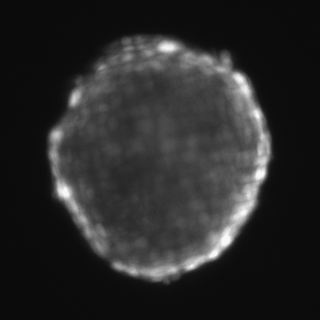
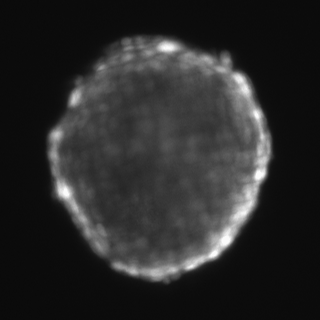
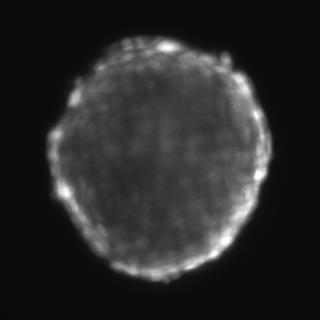
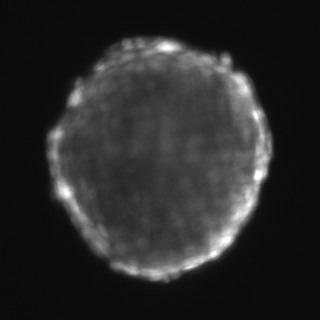

In [17]:
# index of test spheroid
idx = 11

# look at the different TP inputs
fig = px.imshow(to_np(inputs_f[idx]), animation_frame=0, binary_string=True, aspect='equal')
fig.show()

### Quality of focus estimation

<IPython.core.display.Javascript object>


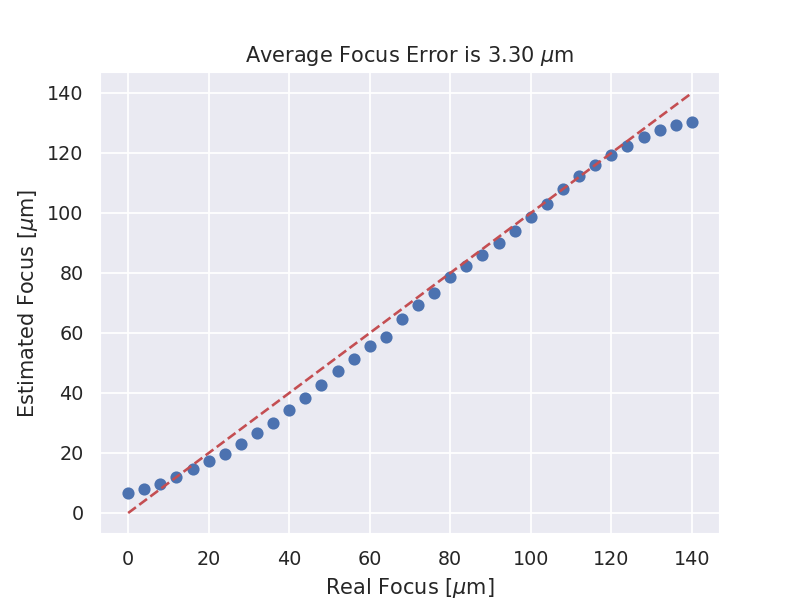

Text(0.5, 1.0, 'Average Focus Error is 3.30 $\\mu$m')

In [18]:
# index of test spheroid
idx = 1

# estimated vs real focus
plt.figure()
plt.scatter(np.arange(0,36,1)*pz,to_np(foci_f[idx])*pz)
plt.plot(np.arange(0,36,1)*pz,np.arange(0,36,1)*pz,'--r')
plt.xlabel("Real Focus [$\mu$m]")
plt.ylabel("Estimated Focus [$\mu$m]")
plt.title(f"Average Focus Error is {np.abs(to_np(foci_f[idx])-np.arange(0,36,1)).mean()*pz:.2f} $\mu$m")

### Results on inputs per focus

<IPython.core.display.Javascript object>


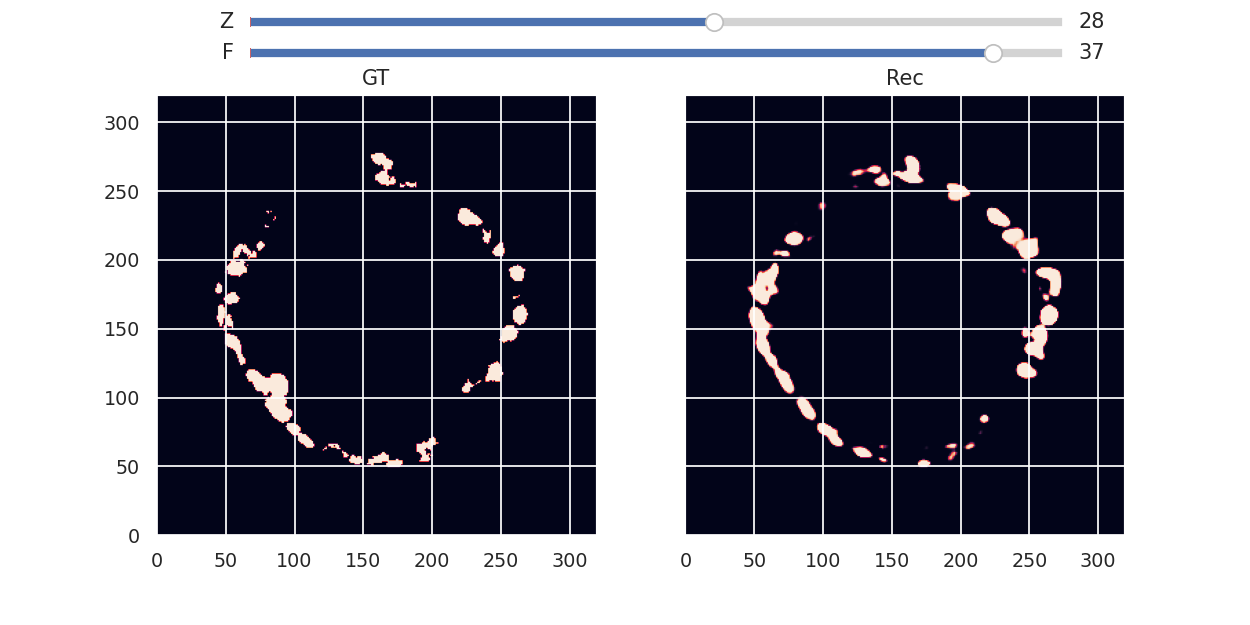

In [19]:
# index of test spheroid
idx = 10

# plot the result vs the GT
target_idx, outputs_idx = to_np(targets_f[idx]), to_np(outputs_f[idx])

# subplots of GT vs Rec as function of Z and F
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
l1 = ax1.imshow(target_idx[15,:,:] > 0, origin = 'lower')
ax1.set_title("GT")
l2 = ax2.imshow(outputs_idx[0,15,:,:], origin = 'lower')
ax2.set_title("Rec")

# sliders on Z and F
axZ = fig.add_axes([0.2, 0.95, 0.65, 0.03])
axF = fig.add_axes([0.2, 0.90, 0.65, 0.03])
sliderZ = Slider(axZ, 'Z', 0, outputs_idx.shape[1]-1, valinit=0, valfmt='%i', valstep=1)
sliderF = Slider(axF, 'F', 0, outputs_idx.shape[0]-1, valinit=0, valfmt='%i', valstep=1)

# update function
def update(val):
    i = int(sliderZ.val)
    j = int(sliderF.val)
    im1 = target_idx[i,:,:] > 0
    im2 = outputs_idx[j,i,:,:]
    l1.set_data(im1)
    l2.set_data(im2)
    fig.canvas.draw_idle()

# take in the current input
sliderZ.on_changed(update)
sliderF.on_changed(update)
plt.show()

### Output folder

In [25]:
# output folder
output_path = Path("Results/" + weights_name.split("Models/")[1] + "/Test Set/")
if output_path.exists() is False:
    output_path.mkdir(parents=True)

### Saving for Watershed in Fiji

In [26]:
# imgs and names for saving
save_imgs = [inputs_f, targets_f, outputs_f]
save_names = ["Tetra.tiff", "Ground_truth.tiff", "Rec3D.tiff"]
metadatas = [{'axes': 'TYX'}, {'axes': 'ZYX'}, {'axes': 'TZYX'}]

# for each test sampel save both sim/exp results
for i,subject_i in enumerate(test_set):
    filename_i = str(subject_i['ST'].path)
    save_imgs_i = [to_np(im[i]) for im in save_imgs]
    stack_path = Path(os.path.join(output_path, filename_i.split(sep='/')[-1].split(sep='.tif')[0]))
    if stack_path.exists() is False: stack_path.mkdir()
    for img, name, meta in zip(save_imgs_i,save_names,metadatas):
        img_name = os.path.join(stack_path, name)
        img = img.astype(np.float32)
        if name == "Rec3D.tiff": img = (img > 0.2).astype(np.uint8)  # binarized outputs to save space
        imwrite(img_name, img, metadata=meta, imagej=True)